# Monte Carlo Not a Monte Cristo Sandwich

In [2]:
%matplotlib inline
# Imports
from clr import AddReference
AddReference("System")
AddReference("QuantConnect.Common")
AddReference("QuantConnect.Jupyter")
AddReference("QuantConnect.Indicators")
from System import *
from QuantConnect import *
from QuantConnect.Data.Custom import *
from QuantConnect.Data.Market import TradeBar, QuoteBar
from QuantConnect.Jupyter import *
from QuantConnect.Indicators import *
from scipy.optimize import minimize
from datetime import datetime, timedelta
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create an instance
qb = QuantBook()

In [3]:
# Set plot size
plt.rcParams["figure.figsize"] = [16,9]

# Time, set the timeframe for the whole of the project 252 trading days in a year
# time_frame = 365

# Select asset data
# @TODO remove SPY add tether USDT
BCT = qb.AddCrypto("BTCUSD")
ETH = qb.AddCrypto("ETHUSD")
BCH = qb.AddCrypto("BCHUSD")
LTC = qb.AddCrypto("LTCUSD")


df = qb.History(qb.Securities.Keys, datetime(2018, 1, 1, 0, 0), datetime(2018, 12, 31, 0, 0) , Resolution.Daily)

In [4]:
dr = df.loc['BTCUSD'].reset_index()
dr_max = dr['time'].max()
dr_min = dr['time'].min()

In [5]:
#spy = pd.DataFrame(df.loc["SPY"]["close"])
btc = pd.DataFrame(df.loc["BTCUSD"]["close"])
eth = pd.DataFrame(df.loc["ETHUSD"]["close"])
bch = pd.DataFrame(df.loc["BCHUSD"]["close"])
ltc = pd.DataFrame(df.loc["LTCUSD"]["close"])

securities = pd.concat([btc,eth,bch,ltc],axis=1)

securities.columns = ['BTC','ETH','BCH','LTC']
securities =  securities.dropna() # if you have a stock 
securities.head()

,BTC,ETH,BCH,LTC
time,,,,
2018-01-02,13480.01,759.03,2326.86,225.22
2018-01-03,14781.51,865.00,2558.58,253.31
2018-01-04,15098.14,938.31,2548.65,244.99
2018-01-05,15144.99,949.00,2362.74,238.91
2018-01-06,16960.01,969.27,2398.00,246.23


In [6]:
mean_daily = securities.pct_change().mean()
mean_daily

BTC   -0.002509
ETH   -0.003009
BCH   -0.004163
LTC   -0.003810
dtype: float64

In [7]:
securities.pct_change().corr()

,BTC,ETH,BCH,LTC
BTC,1.000000,0.819045,0.717903,0.846548
ETH,0.819045,1.000000,0.726335,0.839571
BCH,0.717903,0.726335,1.000000,0.708151
LTC,0.846548,0.839571,0.708151,1.000000


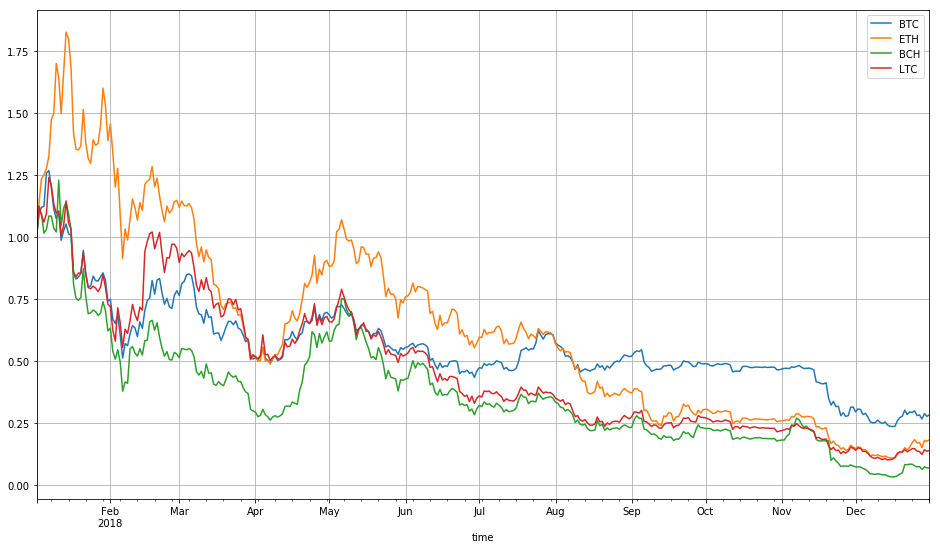

In [8]:
# logs to normalize data
securities_norm = securities/securities.iloc[0]
securities_norm.plot()
plt.grid(True)
plt.xlim(dr_min,dr_max);

In [9]:
securities.pct_change().head()

,BTC,ETH,BCH,LTC
time,,,,
2018-01-02,NaN,NaN,NaN,NaN
2018-01-03,0.096550,0.139612,0.099585,0.124722
2018-01-04,0.021421,0.084751,-0.003881,-0.032845
2018-01-05,0.003103,0.011393,-0.072945,-0.024817
2018-01-06,0.119843,0.021359,0.014923,0.030639


In [10]:
# Shit to remove NAN from Pct_change() 
log_ret = np.log(securities /securities.shift(1))
log_ret.head()



,BTC,ETH,BCH,LTC
time,,,,
2018-01-02,NaN,NaN,NaN,NaN
2018-01-03,0.092169,0.130688,0.094933,0.117536
2018-01-04,0.021194,0.081351,-0.003889,-0.033397
2018-01-05,0.003098,0.011328,-0.075742,-0.025130
2018-01-06,0.113188,0.021134,0.014813,0.030179


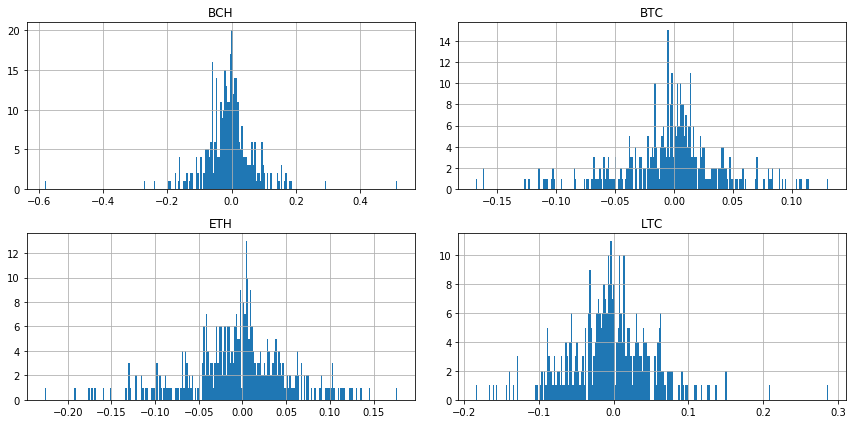

In [11]:
log_ret.hist(bins = 249,
            
            figsize = (12,6));
plt.tight_layout()

In [12]:
log_ret.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
BTC,363.0,-0.003467,0.043890,-0.167940,-0.021350,-0.000353,0.016004,0.131154
ETH,363.0,-0.004681,0.057990,-0.226583,-0.033303,-0.002082,0.028307,0.176957
BCH,363.0,-0.007344,0.079721,-0.581584,-0.046047,-0.004928,0.021585,0.514927
LTC,363.0,-0.005414,0.056388,-0.184431,-0.033563,-0.005665,0.027242,0.287540


In [13]:
log_ret.cov() * 364

,BTC,ETH,BCH,LTC
BTC,0.701197,0.764436,0.935474,0.773141
ETH,0.764436,1.224082,1.253292,1.015310
BCH,0.935474,1.253292,2.313358,1.199811
LTC,0.773141,1.015310,1.199811,1.157388


In [14]:
trys = 50000

weights_multi = np.zeros((trys, len(securities.columns)))
ret_arr = np.zeros(trys)
vol_arr = np.zeros(trys)
sharpe_arr = np.zeros(trys)

for index in range (trys):
    weights = np.array(np.random.random(4))
    weights = weights/ np.sum(weights)
    
    weights_multi[index,:] = weights

    ret_arr[index] = np.sum((log_ret.mean() * weights)* 365)
    
    vol_arr[index] = np.sqrt(np.dot(weights.T,np.dot(log_ret.cov() * 365, weights)))
    
    sharpe_arr[index] = ret_arr[index]/vol_arr[index]

In [15]:
best_loc = sharpe_arr.argmax()
opt_col = pd.DataFrame(weights_multi[best_loc,:])
opt_col = opt_col.transpose()
opt_col.columns = ['BTC','ETH','BCH','LTC']
opt_col

,BTC,ETH,BCH,LTC
0,0.932577,0.032637,0.010168,0.024618


In [16]:
saft_loc = vol_arr.argmin()
opt_col = pd.DataFrame(weights_multi[saft_loc,:])
opt_col = opt_col.transpose()
opt_col.columns = ['BTC','ETH','BCH','LTC']
opt_col

,BTC,ETH,BCH,LTC
0,0.928081,0.011912,0.002844,0.057163


In [17]:
# The fact that this is negative is actually awful
sharpe_arr.max()

-1.5494275759820775

In [18]:
max_sr_ret = ret_arr[best_loc]
max_sr_vol = vol_arr[best_loc]
min_ret = ret_arr[saft_loc]
min_vol = vol_arr[saft_loc]

In [29]:
#https://www.youtube.com/watch?v=rR6dUWT-7Ls

## no pain no gain

In [19]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 364
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 364, weights)))
    sr = ret/vol
    return np.array([ret, vol, sr])

def neg_sharpe(weights):
    return  get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    return np.sum(weights) - 1

def minimize_volatility(weights):
    return  get_ret_vol_sr(weights)[1] 

In [20]:
cons = ({'type' : 'eq', 'fun': check_sum})
init_guess = [0.25, 0.25, 0.25, 0.25]
bounds = ((0, 1), (0, 1), (0, 1), (0, 1))

In [21]:
# Sequential Least SQuares Programming (SLSQP).
opt_results = minimize(neg_sharpe,
                       init_guess,
                       method = 'SLSQP',
                       bounds = bounds,
                       constraints = cons)

In [22]:
opt_results

     fun: 1.5401336191165795
     jac: array([1.78909242e-01, 1.49011612e-08, 8.39329675e-01, 5.03663138e-01])
 message: 'Optimization terminated successfully.'
    nfev: 36
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.00000000e+00, 1.00000000e+00, 1.00613962e-16, 0.00000000e+00])

In [23]:
opt_col = pd.DataFrame(opt_results.x)
opt_col = opt_col.transpose()
opt_col.columns = ['BTC','ETH','BCH','LTC']
opt_col

,BTC,ETH,BCH,LTC
0,0.0,1.0,1.006140e-16,0.0


In [25]:
opt_ret_vol_sr = get_ret_vol_sr(opt_results.x)
ret_vol_sr_res = pd.DataFrame(opt_ret_vol_sr)
ret_vol_sr_res = ret_vol_sr_res.transpose()
ret_vol_sr_res.columns = ['Return','Volatility','Sharpe']
ret_vol_sr_res

,Return,Volatility,Sharpe
0,-1.703977,1.106382,-1.540134


In [55]:
frontier_ylim_max = sharpe_arr.max()
frontier_ylim_min = sharpe_arr.min()
# Adjust the extra numbers as needed
# For negatives sharps it causes problems
frontier_y = np.linspace(-2.7, -1.2, 100)

In [56]:
frontier_volatility = []

for possible_return in frontier_y:
    # function for return
    cons = ({'type':'eq','fun': check_sum},
            {'type':'eq','fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,
                      init_guess,
                      method = 'SLSQP',
                      bounds = bounds,
                      constraints = cons)
    
    frontier_volatility.append(result['fun'])

In [57]:
# Values to plot SLSQP
arr_t = ret_vol_sr_res.values
vol_slsqp = arr_t[0,1]
ret_slsqp = arr_t[0,0]
sr_slsqp = arr_t[0,2]

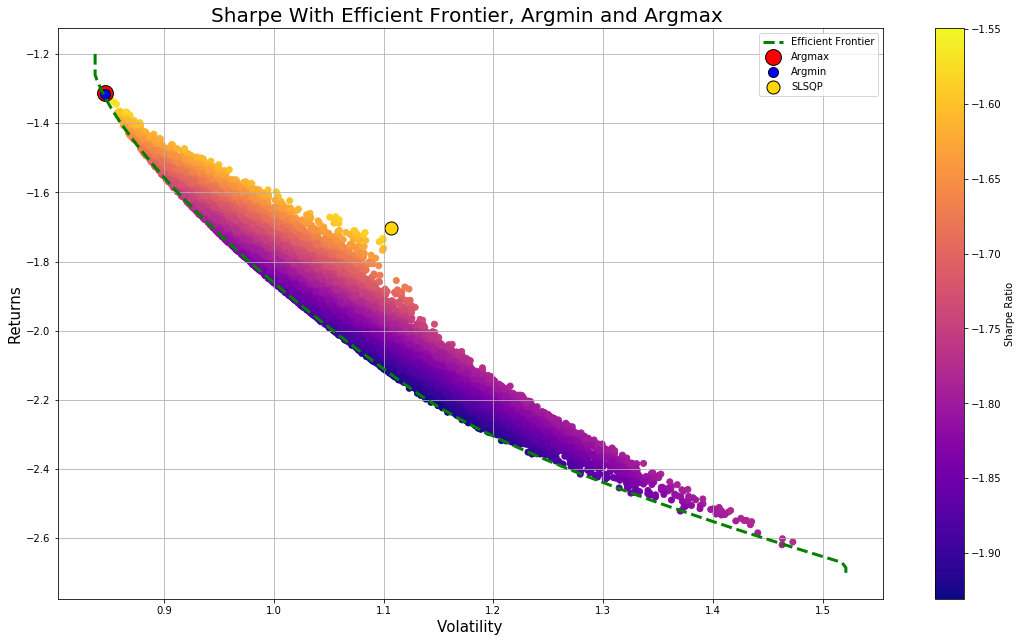

In [59]:
fig = plt.figure()
ax = fig.add_subplot(111)

main_plot = plt.scatter(vol_arr,
            ret_arr,
            c = sharpe_arr,
            cmap = 'plasma')
plt.colorbar(label = 'Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f
# Efficient Frontier
front_plot = plt.plot(frontier_volatility,
         frontier_y,
         'g--',
         linewidth = 3,
         label = 'Efficient Frontier')

# Add dot for max SR, min vol, & SLSQP
red = plt.scatter(max_sr_vol,
            max_sr_ret,
            c = 'red',
            s = 250,
            edgecolors = 'black',
            label='Argmax')

blue = plt.scatter(min_vol,
            min_ret,
            c = 'blue',
            s = 100,
            edgecolors = 'black',
            label='Argmin')
                   

gold = plt.scatter(vol_slsqp,
            ret_slsqp,
            c = 'gold',
            s = 170,
            edgecolors = 'black',
            label='SLSQP')


ax.legend()

plt.title('Sharpe With Efficient Frontier, Argmin and Argmax ',fontsize=20)
plt.ylabel('Returns',fontsize=15)
plt.xlabel('Volatility',fontsize=15)

plt.grid(True)

fig.set_size_inches(18.5, 10.5)
plt.show();